In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import os 

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (6.75, 5),
          'lines.linewidth': 3.0, 
          'axes.labelsize': 'xx-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'xx-large', 
          'ytick.labelsize':'xx-large', 
          'legend.fontsize': 'xx-large', 
          'font.size': 11, 
          'font.family': 'serif', 
          'mathtext.fontset': 'dejavuserif', 
          'axes.titlepad': 12, 
          'axes.labelpad': 12}
plt.rcParams.update(params)

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [2]:
# Simulation parameters
s = 1.0    # rest length
tf = 15.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67

t_data = [0.0, tf]

force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[6]}

# Solvers
models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
             'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, dim)}
#models_ef = {'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, dim), 
#             'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, dim),
 #            'GLS': cbmos.CBModel(ff.LinearExponential(), ef.solve_ivp, dim)}

In [3]:
# parameters fitted to relaxation time t=1.0h
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}
filename_ending = {'cubic': '_cubic', 'pw. quad.': '_pwq', 'GLS': '_gls'}

In [4]:
def cubic_prime(r, mu, s, rA):
    return mu*(r-rA)*(3*r-2*s-rA)
    
def pwq_prime(r, muA, rA, muR, rR, s):
    return 2*(muR/rR*(1-r/rR)-muA/rA*(1-r/rA))
    
def gls_prime(r, mu, s):
    return mu/(1+r-s)

In [5]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.set_aspect('equal')
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    plt.show()

# Global adaptive time-stepping for a growing monolayer

In [6]:
rate = 3.0

In [7]:
npr.seed(seed)
cell_list = [
        cl.Cell(
            0, [0., 0.],
            proliferating=True, division_time_generator=lambda t: npr.exponential(rate) + t)
        ]

Nothing to delete.


/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:214: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w)


Nothing to delete.


/home/kubuntu1804/Documents/cbmos/cbmos/solvers/euler_forward.py:443: RuntimeWarning: divide by zero encountered in double_scalars
  dt_s = 2.0/abs(w)


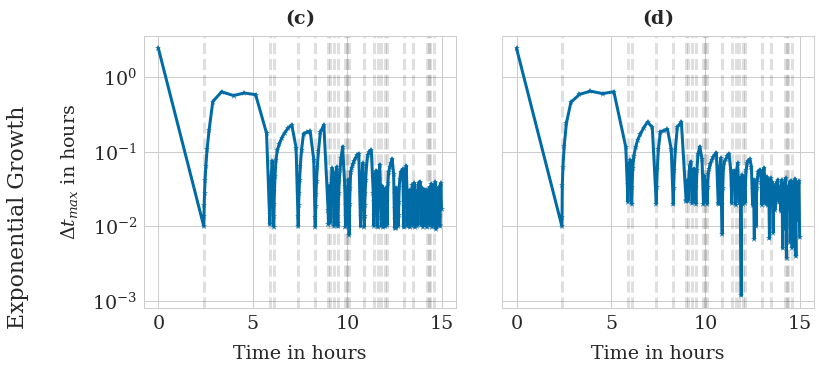

In [14]:
colors = [defcolors[0], defcolors[5], defcolors[6]]

# Combine into single figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})
#fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey='row', gridspec_kw={'hspace':0.2, 'wspace': 0.15})


force = 'cubic'

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('time_points'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, min_event_resolution=0.1, seed=seed)
dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')

n_cells = [len(clt) for clt in history]
division_time_indices = np.where(np.diff(n_cells) == 1)[0]
division_times = np.array(ts)[division_time_indices]
for xc in division_times:
    ax1.axvline(x=xc, color='black', linestyle="--", alpha=0.125)
    
ax1.semilogy(ts[:-1],  dts,'-*')
ax1.set(xlabel='Time in hours')
ax1.set_title(r'$\bf{(c)}$')

ax1.set(ylabel='$\Delta t_{max}$ in hours')
ax1.text(-8, 0.0005, 'Exponential Growth', fontsize=22, rotation='vertical')
#ax1.text(15, 6, 'Globally adaptive', fontsize=22)
#ax1.legend()

try:
    os.remove('step_sizes'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('time_points'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')
try:
    os.remove('AFs'+filename_ending[force]+'.txt')
except FileNotFoundError:
    print('Nothing to delete.')

ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.01, "eta":0.0001, "out": filename_ending[force], 'write_to_file': True, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True, 'switch': False}, min_event_resolution=0.1, seed=seed)
dts = np.loadtxt('step_sizes'+filename_ending[force]+'.txt')

n_cells = [len(clt) for clt in history]
division_time_indices = np.where(np.diff(n_cells) == 1)[0]
division_times = np.array(ts)[division_time_indices]
for xc in division_times:
    ax2.axvline(x=xc, color='black', linestyle="--", alpha=0.125)
    
ax2.semilogy(ts[:-1],  dts,'-*')
ax2.set(xlabel='Time in hours')
#ax2.set(ylabel='$\Delta t_{max}$ in hours')
#ax2.text(15, 6, 'Locally adaptive', fontsize=22)
ax2.set_title(r'$\bf{(d)}$')

#ax2.set(ylabel='$\Delta t_{max}$ in hours')
plt.savefig('exp_growth.pdf', bbox_inches='tight')

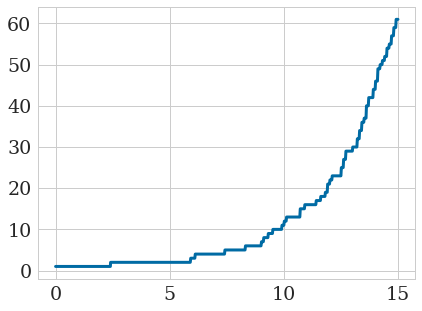

In [10]:
plt.plot(ts, [len(clt) for clt in history ])

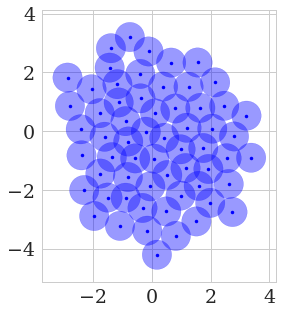

In [13]:
plot_population(history[-1])

In [12]:
%%time 
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, 'jacobian': models_ef[force].jacobian, 'force_args': params[force]}, seed=seed)


CPU times: user 2.75 s, sys: 329 ms, total: 3.08 s
Wall time: 3.46 s


In [13]:
%%time 
ts, history = models_ef[force].simulate(cell_list, t_data, params[force], {"eps": 0.001, "eta":0.0001, 'jacobian': models_ef[force].jacobian, 'force_args': params[force], 'local_adaptivity': True}, seed=seed)


CPU times: user 1.46 s, sys: 0 ns, total: 1.46 s
Wall time: 1.67 s
